# Payout Schedule & Cash Flow Analysis for a Bond Portfolio

When holding a portfolio of bonds, it's of particular importance to manage the expected payback (be it Interest Payments or Principal) to be received in the next months, quarters and even years. This allows one to anticipate the expected cash flows from the coupons and the receipt of principal payments on bonds that are nearing maturity date, and to look at total amounts in the desired currency. Thanks to the LSEG Data Library for Python and the Instrument Pricing Analytics (IPA) APIs, this is made simple. 

Follow the steps below to get more insight into your Bond Portfolio.

## Getting Started
To get started we will need to import the LSEG Data Library for Python library. The data Library provides the analytics to retrieve bond payment schedules as well as FX Forward spot rates based on these schedules.  As part of our presentation, we'll include popular Python graphing capabilities.

In [1]:
# LSEG packages
import lseg.data as ld
from lseg.data.content.ipa import financial_contracts
from lseg.data.content.ipa.financial_contracts import bond
from lseg.data.content.ipa.financial_contracts import cross

# Common Python packages
from lseg.data.content import search
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import plotly.graph_objects as go

ld.__version__

'2.0.1'

In [2]:
# Open a session into the desktop (LSEG Workspace)
ld.open_session()

<lseg.data.session.Definition object at 0x7f3549b39a90 {name='codebook'}>

## Process Workflow
 The following workflow outlines concrete steps involved in generating our cash flow analysis.  The steps have been intentionally broken out into well-defined segments for the purposes of reusability as well as a basis for understanding the processing details.

 1. **Portfolio Definition**
 
 The portfolio definition provides the user multiple options to create a list of bonds required for analysis.  Whether working directly with your own portfolios defined within the desktop to creating simple collections for what-if analysis, each option will generate a common definition require for processing and analysis.
 
 2. **Schedule Generation**
 
 Using the portfolio of bonds, the schedule generation utilizes the power of the IPA bond interfaces to create our payment schedules and what the interest will be for each.
 
 3. **Currency Conversion**
 
 The collection of bonds will likely be issued in different currencies.  The goal of the analysis is to standardize the cash flow in a single currency.  Using the power of the IPA FX Forward analytics engine, we can generate the FX Forward rates based on the bond schedules defined in the previous step.
 
 4. **Analysis**
 
 Finally, we can put it all together by bucketing our results into a suitable generation of charts showing the future interest and principals payments over a selected period.

 ##  1. Portfolio Definition
To demonstrate bond cash flow, we will offer multiple ways to define a list of bonds representing our portfolio.  In all cases, the output will be a collection, or list, of RICs identifying the portfolio of bonds.  In a later step, the list is fed into our analytics engine to help generate our cash flow schedule.  The following choices are offered:

* **Define a portfolio of bonds on the desktop**

 Users that prefer to manage their portfolios using the Portfolio definition app defined within the desktop, via PAL (Portfolio and List), can directly extract the list into their applications using the *Portfolio()* function.  
 
 For example: <em>ld.get_data("Portfolio(12345)", "TR.RicCode")</em> where 12345 is the Portfolio Code defined in the PAL application within the desktop<br>

In [3]:
# If a portfolio has been defined within the desktop, the following function will extract the list...
def get_portfolio(code):
    df = ld.get_data(f'Portfolio({code})', ['TR.PortfolioShares', 'TR.PortfolioConstituentName'])
    if "Instrument" not in df.columns:
        print(f"Impossible to open the portfolio {code}.")
    return df

In [19]:
# Extract the list of RICS based on the specific portfolio code
portfolio = get_portfolio("Cashflow")
portfolio

,Instrument,Portfolio Shares,Issuer Name
0,36966TBD3=RRPS,50000,GENERAL ELECTRIC CO
1,36966TFS6=RRPS,20000,GENERAL ELECTRIC CO
2,CH29287789=RRPS,100000,SHELL INTERNATIONAL FINANCE BV
3,US151297811=RRPS,100000,INTERNATIONAL BUSINESS MACHINES CORP


* **Generate the bonds for a specific company**

 In some cases, it may be useful to generate a portfolio of outstanding bonds for a specific company to perform a what-if analysis.  This mechanism utilizes the Search call to select the list of bonds based on a specific company identifier. For simplicity, the algorithm provides 2 mechanisms to identify the company of interest - using the company ID (*Organization ID / Perm ID*), or by specifying the company ticker. If choosing the company ID approach, refer to the **Company Selection** paragraph defined within the [Debt Structure Analysis](https://developers.lseg.com/en/article-catalog/article/debt-structure-analysis-on-an-organizational-level) article for details.<br>

In [5]:
def search_bonds(id_list, ticker=False):
    # Ensure the 'id_list' is a list
    if not isinstance(id_list, list):
        id_list = [id_list]
        
    # Determine the type of filter based on the issuer flag
    ids = " ".join(f"'{w}'" for w in id_list)
    
    if ticker:
        id_filter = f"IssuerTicker in ({ids})"
    else:
        id_filter = f"ParentOAPermID in ({ids})"
    
    # Execute the search...
    response = ld.discovery.search(
        # The 'view' represents a specific domain of content we wish to search across.        
        view = search.Views.FIXED_INCOME_INSTRUMENTS,
        
        # The 'filter' parameter is a powerful, criteria-based, syntax that allows us to filter for 
        # specific results.  Ensure the bonds are active and have not matured.
        filter = f"{id_filter} and \
                   IsActive eq true and \
                   AssetStatus ne 'MAT'",

        # Define the upper limit of rows within our result set.  This is a system imposed maximum value.
        top = 10000,
        
        # The 'select' parameter determines the fields of interest in our output.
        select = "RIC"
    )
    
    if not response.empty:
        df = response.dropna()
        return df['RIC'].tolist()
    
    return []

In [28]:
# Search for bonds based on a organization ID (PermID) - Example: IBMs PermID is 4295904307
portfolio = search_bonds('4295904307')
print(f"Found a total of {len(portfolio)} bonds: [{portfolio[:5]}]")

Found a total of 56 bonds: [['US194445610=', 'US161784508=', '459200KS9=', '459200AM3=', 'US099109963=']]


In [7]:
# Alternatively, search for bonds based on the Issuer ticker
portfolio = search_bonds('IBM', True)
print(f"Found a total of {len(portfolio)} bonds: [{portfolio[:5]}]")

Found a total of 49 bonds: [['US194445610=', 'US161784508=', '459200KS9=', '459200AM3=', 'US099109963=']]


> **Note**: In most cases, using the company ticker will generate an accurate list of bonds.  However, there may be instances where Search will associate a specific ticker belonging to multiple organizations or not properly associating bonds to the ticker, thus generating a different list of bonds.  This may be due to Search returning results that closely match the list of tickers, as opposed to finding the company ID. To ensure an accurate list, you should utilize the company ID as your company identifier.<br>

* **Manually create a list of bonds**

 You have the option to create your own list manually, whether typing in the collection or pulling in from a text file.  This option is useful when testing your different collections.

In [55]:
# For simple testing, manually define the portfolio by entering the RIC along with the units/PAR holdings for each
portfolio = [('US151297811=', 20000), ('36966TBD3=', 50000), ('CH29287789=', 100000), ('RU011428878=', 500000)]
portfolio

[('US151297811=', 20000),
 ('36966TBD3=', 50000),
 ('CH29287789=', 100000),
 ('RU011428878=', 500000)]

 ## 2. Schedule Generation
In this step, we'll be utilizing the Instrument Pricing Analytics (IPA) interfaces for bonds to generate our cash flow schedules. Using the portfolio created above, we will define a universe of bonds required by the IPA bond interface and pull out the desired properties, most importantly, the frequency and specific dates each bond pays.  In addition to the payment schedule, we also included a number of other fields, for display purposes.

IPA will do all the heavy lifting of determining the specific dates, taking into account country schedules and holidays.  This will allow us to accurately report cash flow for a specific month. If you would like more information about IPA, please visit this [site](https://developers.lseg.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis/documentation#ipa-financial-contracts-getting-started) for more information.

### Notional Amount
The *Notional Amount* represents the position taken for each bond.  By default, the IPA bond interface will assume an amount of 1,000,000 units.  In the above steps outlined within the Portfolio Definition section, we provided the ability for users to define their position for each bond.  In the case of pulling out bonds for a specific company, we rely on the default set by IPA.  In all cases, our payments will be affected by the position defined which will be used to drive the cash flow presented in a later step.

In [69]:
# The universe represents the bonds we'll inject into the IPA bond engine.  Depending on the portfolio,
# each universe entry may contain a specific notional amount.  Otherwse, the default will be used.
universe = []

portfolio = portfolio.to_numpy() if isinstance(portfolio, pd.DataFrame) else portfolio
for item in portfolio:
    if isinstance(item, str):
        universe.append( 
            bond.Definition(
                instrument_code = item
            ) 
        )
    else:
        universe.append(
            bond.Definition(
                instrument_code = item[0],
                notional_amount = item[1]
            )
        )

Retrieve the payment schedules from IPA using our derived universe of bonds.

The following IPA function uses the universe of bonds defined above to retrieve the payment schedules for each.  The following key properties are specified:
 - **NotionalCcy**<br>
   The currency issued for the bond
 - **CashFlowDatesArray**<br> 
   The future payment dates for the bond
 - **CashFlowInterestAmountsInDealCcyArray**<br>
   Based on the interest payments and position, the payment amount at each date
 - **CashFlowCapitalAmountsInDealCcyArray**<br>
   Based on the principal payments and position, the payment amount at each date

In [70]:
definition = financial_contracts.Definitions(
    universe = universe,
    fields = ["InstrumentCode",
              "NotionalCcy",
              "PositionInDealCcy",
              "InterestPaymentFrequency", 
              "CashFlowDatesArray",
              "CashFlowInterestAmountsInDealCcyArray",
              "CashFlowCapitalAmountsInDealCcyArray"
             ]
)
response = definition.get_data()

In [71]:
bonds = response.data.df.dropna()
bonds

,InstrumentCode,NotionalCcy,PositionInDealCcy,InterestPaymentFrequency,CashFlowDatesArray,CashFlowInterestAmountsInDealCcyArray,CashFlowCapitalAmountsInDealCcyArray
0,US151297811=,JPY,20000,SemiAnnual,"[2025-05-02T00:00:00Z, 2025-11-03T00:00:00Z, 2...","[30.0, 30.0, 30.0, 30.0]","[0.0, 0.0, 0.0, 20000.0]"
2,CH29287789=,CHF,100000,Annual,"[2025-08-21T00:00:00Z, 2026-08-21T00:00:00Z, 2...","[875.0, 875.0, 875.0, 875.0]","[0.0, 0.0, 0.0, 100000.0]"
3,RU011428878=,USD,500000,SemiAnnual,"[2025-03-31T00:00:00Z, 2025-09-30T00:00:00Z, 2...","[1031.24999999999, 937.499999999992, 843.74999...","[2500.0, 2500.0, 2500.0, 2500.0, 2500.0, 2500...."


## 3. Currency Conversion
The set of bonds returned may be represented in multiple currencies or in a currency we do not want to present.  The goal of our exercise is to standardize the cash flow based on a selected, base currency, for example, the Euro (EUR).  The conversion algorithm will utilize the IPA Fx Forward analytics engine to compute the exchange rate on a future date.  In the above table, the *CashFlowDatesArray* represents our future coupon payment dates.  Using this array, coupled with the issued currency *NotionalCcy*, we will compute an array of projected Fx conversion rates which will drive the interest calculations.

#### Generate conversion arrays
For each bond in our portfolio, generate the conversion factors.

In [72]:
# Create the FX Cross definition for each leg based on the cash flow dates
def get_fx_analytics(asset, currency):
    universe = []

    cross_code = f'{asset.NotionalCcy}{currency}'

    # Pull out the legs based on the cash flow dates...
    for dt in asset.CashFlowDatesArray:
        leg = cross.LegDefinition(end_date = dt)

        universe.append(cross.Definition(
                                fx_cross_type=cross.FxCrossType.FX_FORWARD,
                                fx_cross_code=cross_code,
                                legs = [leg]
        ))

    definition = financial_contracts.Definitions(
                                        universe = universe,
                                        pricing_parameters=cross.PricingParameters(
                                            valuation_date=f"{datetime.now().strftime('%Y-%m-%d')}"
                                        ),
                                        fields=[
                                            "InstrumentDescription", 
                                            "FxOutrightCcy1Ccy2", 
                                            "StartDate", 
                                            "EndDate", 
                                            "ErrorMessage"]
    )
    response = definition.get_data()
    return response.data.df

In [73]:
# For each bond, request for FX spot rates
def get_rates_array(asset, currency):
    if asset.NotionalCcy != currency:
        fx = get_fx_analytics(asset, currency)
        if (fx is None or fx["FxOutrightCcy1Ccy2"][0] is None):
            return [0] * len(asset.CashFlowDatesArray)
        return fx["FxOutrightCcy1Ccy2"].tolist()
    else:
        return [1] * len(asset.CashFlowDatesArray)

# Build a new column of FX rates for the entire portfolio
def generate_conversion_array(data, currency):
    conversionRates = []
    for entry in data.itertuples():
        conversionRates.append(get_rates_array(entry, currency))
        
    # Ensure conversionRates is treated as an object array
    conversionRates = np.array(conversionRates, dtype=object)

    # Make a copy of the data if it is a slice
    data = data.copy()

    # Set the new column with conversionRates
    data['CurrencyRateArray'] = conversionRates
    
    return data

In [74]:
# Based on the base currency, generate our FX conversion rates for each payment date
base_currency = "EUR"
bonds = generate_conversion_array(bonds, base_currency)

In [75]:
bonds

,InstrumentCode,NotionalCcy,PositionInDealCcy,InterestPaymentFrequency,CashFlowDatesArray,CashFlowInterestAmountsInDealCcyArray,CashFlowCapitalAmountsInDealCcyArray,CurrencyRateArray
0,US151297811=,JPY,20000,SemiAnnual,"[2025-05-02T00:00:00Z, 2025-11-03T00:00:00Z, 2...","[30.0, 30.0, 30.0, 30.0]","[0.0, 0.0, 0.0, 20000.0]","[0.622023143810195, 0.627886088941657, 0.63303..."
2,CH29287789=,CHF,100000,Annual,"[2025-08-21T00:00:00Z, 2026-08-21T00:00:00Z, 2...","[875.0, 875.0, 875.0, 875.0]","[0.0, 0.0, 0.0, 100000.0]","[1.07415141359451, 1.09745659470821, 1.1211777..."
3,RU011428878=,USD,500000,SemiAnnual,"[2025-03-31T00:00:00Z, 2025-09-30T00:00:00Z, 2...","[1031.24999999999, 937.499999999992, 843.74999...","[2500.0, 2500.0, 2500.0, 2500.0, 2500.0, 2500....","[0.95916060015796, 0.94967677262766, 0.9399236..."


## 4. Cash Flow Analysis
Now that we have in place the payment schedules and the corresponding conversion rates, prepare the cash flow metrics required to present our cash flow graph.

In [76]:
# Define the algorithm to build our cash flow table for the entire portfolio           
def build_cash_flow(data):
    dates = []
    coupons = []
    capital = []

    # Process each bond, accumulating the interest and capital for each.
    for i, r in data.iterrows():
        dates.extend(r['CashFlowDatesArray'])
        coupons.extend(list(np.multiply(r['CashFlowInterestAmountsInDealCcyArray'], r['CurrencyRateArray'])))
        capital.extend(list(np.multiply(r['CashFlowCapitalAmountsInDealCcyArray'], r['CurrencyRateArray'])))
        
    # Collect the computed values into a dataframe
    df = pd.DataFrame()
    df['Dates'] = dates
    df['Interest'] = coupons
    df['Capital'] = capital
    return df

In [77]:
# Generate the metrics used in our analysis
cashflow = build_cash_flow(bonds)

### Visualization and analysis of results
The following function provides the analysis of our metrics in a standard graph.  The algorithm provides the ability to bucket the analysis on a monthly, quarterly, or annual basis.  The algorithm will choose an appropriate representation of the cash flow.

In [78]:
def graph_cash_flow(df, bucket, period):
    start = datetime.now()
        
    # We'll use the 'Period' column to define our buckets within the chart
    df['Period'] = pd.to_datetime(df['Dates'], format="%Y-%m-%dT%H:%M:%SZ")
    
    # Filter out dates that fall outside of our specified period
    if bucket=="Y":
        df = df[df.Period.between(start, start + relativedelta(years=+period))]
    elif bucket=="Q":
        df = df[df.Period.between(start, start + relativedelta(months=+3*period))]    
    elif bucket=="M":
        df = df[df.Period.between(start, start + relativedelta(months=+period))]
    else:
        return f"Bucket {bucket} not supported"

    # Merge the dataframes to fill date gaps
    rangedf = pd.DataFrame({"Period" : pd.date_range(start=start.strftime("%Y-%m-%d"), periods=period, freq=bucket)})    
    df = pd.concat([df, rangedf])
    
    # Group and accumulate the values within our defined buckets
    per = df.Period.dt.to_period(bucket)
    df = df.groupby(per).sum()

    # Chart the results...
    fig = go.Figure()
    name = 'Debt Profile, ' + base_currency
    fig.layout.template='plotly_dark'
    trace_int = go.Bar(name='Interest', x=df.index.astype(str), y=df['Interest'])
    trace_cap = go.Bar(name='Capital', x=df.index.astype(str), y=df['Capital'])
    fig.add_trace(trace_cap)
    fig.add_trace(trace_int)
    fig.update_layout(barmode='stack')
    fig.update_layout(
        margin=dict(t=5, b=5, l=5, r=5),
        plot_bgcolor='#1A1A1D',
        paper_bgcolor='#1A1A1D',
        yaxis=dict(gridcolor='black', gridwidth=1, zerolinecolor='black', zerolinewidth=1, 
                   side='right', color='#D6D6D5', linecolor='#D6D6D5', ticks='outside'),
        xaxis=dict(gridcolor='black', gridwidth=1, zerolinecolor='black', zerolinewidth=1, 
                   color='#D6D6D5', linecolor='#D6D6D5', ticks='outside'),
        colorway=['#6978F7', '#A325E9', '#96E05D', '#4A7FB9', '#E75A2D', '#FBE55A', '#8C8C8D', '#5A54F6'],
        legend=dict(font=dict(color='#D6D6D5'), orientation='v', yanchor='top', xanchor='center', y=1.05, x=0.1),
        title = dict(text=name, xanchor='center', yanchor='top', x=0.45, font=dict(color='#D6D6D5'))
    )
    return fig

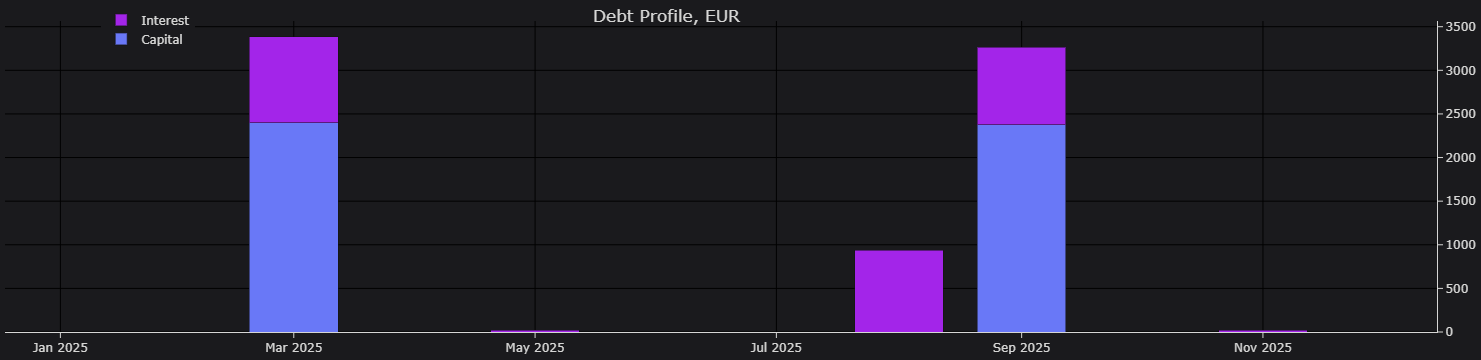

In [79]:
# Analysis over the next 12 months
graph_cash_flow(cashflow, 'M', 12)

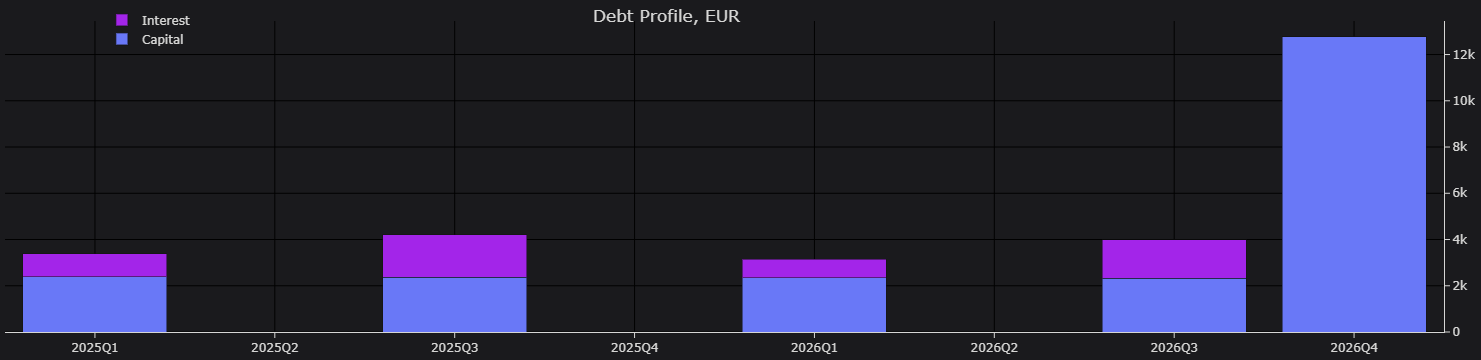

In [80]:
# Analyze over the next 8 quarters...
graph_cash_flow(cashflow, 'Q', 8)

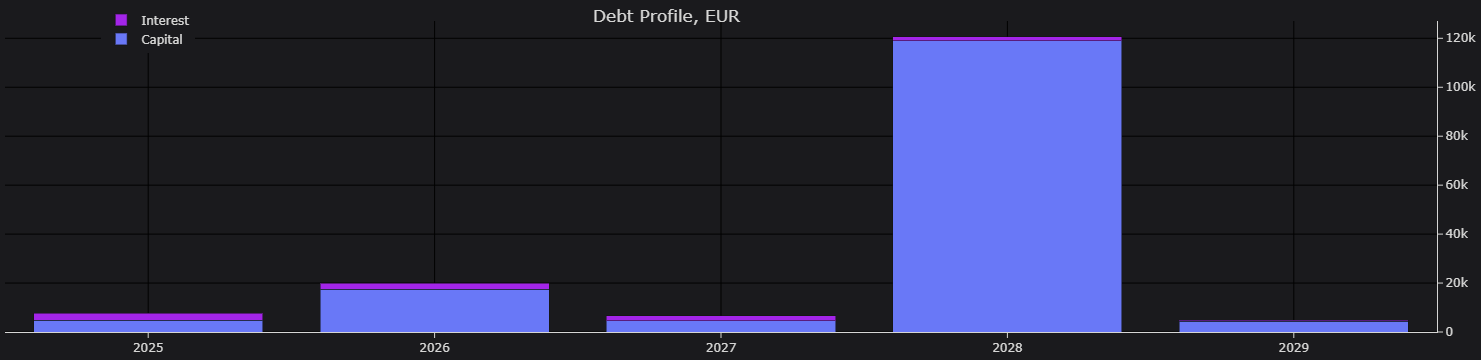

In [81]:
# And finally, over the next 5 years...
graph_cash_flow(cashflow, 'Y', 5)

## Conclusions

As you can see, leveraging the capabilities of the Financial Contracts API in Instrument Pricing Analytics, we have had to do very little coding to resolve a schedule of coupon and principal payments on a Portfolio/List of bonds. Keep in mind that in this simple, yet illustrative example, we looked at different ways of defining our bond universe, then we analyzed the schedule of coupon payments and principal at maturity, we applied currency conversion so as to be able, to sum up, expected cash flow in potentially different currencies, and finally, we were able to output this to a chart view - be it in Months, Quarters or Years.

Key takeaways are that the heavy lifting of the coupon calculation, payment schedules, and FX Outrights are delivered seamlessly from IPA allowing for us to focus on the preparation of the portfolios and analysis of output. This means that any Bond Portfolio holder, regardless of their programming knowledge, is now able to leverage our APIs and make them do the hard work.